# Series 3, Online Convex Programming

In [86]:
import math

import numpy as np
import pandas as pd
import scipy

from scipy.linalg import norm
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
# Ensure consistency across runs.
np.random.seed(1337)

In [3]:
Xtrain = np.genfromtxt('data/Xtrain.csv', delimiter=',')
Ytrain = np.genfromtxt('data/Ytrain.csv', delimiter=',', dtype='int8')
Xtest = np.genfromtxt('data/Xtest.csv', delimiter=',')
Ytest = np.genfromtxt('data/Ytest.csv', delimiter=',', dtype='int8')

In [4]:
def permute_data(x, y):
    """Shuffles both numpy arrays in unison."""
    perm = np.random.permutation(x.shape[0])
    return x[perm, :], y[perm]

Xtrain, Ytrain = permute_data(Xtrain, Ytrain)
Xtest, Ytest = permute_data(Xtest, Ytest)

In [76]:
from sklearn.utils.estimator_checks import check_estimator

class OnlineClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.w = None
        self.lbd = 1.0
        self.set_params(**params)
        
    def fit(self, X, y):
        raise Exception("Not implemented in abstract class.")
        
    def get_params(self, deep=True):
        return {"lbd": self.lbd}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def predict(self, X):
        signs = np.sign(np.inner(self.w, X))
        signs[signs == 0] = -1
        return signs.astype('int8')

In [97]:
def project_L1(w, a):
    """Project to L1-ball, as described by Duchi et al. [ICML '08]."""
    z = 1.0 / (a * a)
    if norm(w, 1) <= z:
        # No normalization required.
        return w
    
    mu = -np.sort(-w)
    cs = np.cumsum(mu)
    rho = -1
    for j in range(len(w)):
        if mu[j] - (1.0 / (j + 1)) * (cs[j] - z) > 0:
            rho = j
    
    theta = (1.0 / (rho + 1)) * (cs[rho] - z)
    return np.sign(w) * np.fmax(w - theta, 0)

In [112]:
def project_L2(w, lbd):
    """l2 regularization, using an l-2 ball of radius $\sqrt{\lamda}$.
    """
    sqrt_lambda = np.sqrt(lbd)
    w_norm = norm(w, 2)
    regularizer = 1.0 / (sqrt_lambda * w_norm)
    return w * min(1.0, regularizer)

## Online Support Vector Machine

In [113]:
class OnlineSVMClassifier(OnlineClassifier):
    """Online SVM with L2 regularization."""
    
    def fit(self, X, y):
        assert X.shape[0] == y.shape[0]
        # Initialize the model.
        w = np.zeros(X.shape[1], dtype='float64')
        
        # Iterate just once through our data (this works, and is one
        # of the key advantages of online SVMs).
        for t, (x, label) in enumerate(zip(X, y)):
            # The adaptive learning rate.
            eta = 1.0 / np.sqrt(t + 1)
            
            # Compute the loss using the hinge loss formula.
            hinge = label * np.inner(w, x)
            
            # If the hinge loss is smaller than 0, then we classified the
            # current data point completely wrong, and if it's between 0 
            # and 1, we were right but not confident enough (we want our 
            # decisions to be confident (hinge coef > 1) since we want to 
            # maximize the margin between our classes).
            # In either of these cases we want to update our model and
            # project it back to the specified l2 ball, in order to keep
            # its complexity under control.
            if hinge < 1:
                w += eta * label * x
                w = project_L2(w, self.lbd)

        self.w = w
        return self
    
# check_estimator(OnlineSVMClassifier)

## Online Logistic Regression

In [114]:
def sigmoid(exp):
    # TODO: consider simplifying this.
    return np.exp(-scipy.misc.logsumexp([0, exp]))


class OnlineLogisticRegressionClassifier(OnlineClassifier):
    """Online logistic regression with L1 regularization."""
    def fit(self, X, y):
        # Implementation copied from sample solution.
        # Despite what was mentioned in the assignment, there was nothing
        # about online logistic regression in the lecture/tutorial slides,
        # or in the textbook.
        assert X.shape[0] == y.shape[0]
        w = np.zeros(X.shape[1])
        
        for t, (x, label) in enumerate(zip(X, y)):
            eta = 1.0 / np.sqrt(t + 1)
            exp = label * np.inner(w, x)
            predicted = sigmoid(exp)
            
            w += eta * predicted * label * x
            w = project_L1(w, self.lbd)
            
        self.w = w

## Analysis of algorithms

In [115]:
cls = OnlineSVMClassifier()

logistic_cls = OnlineLogisticRegressionClassifier()

### A grid search for optimal $\lambda$

In [116]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

parameters = {
    'lbd': [0.001, 0.005, 0.01, 0.05, 0.1]
}
gs = GridSearchCV(cls, parameters)
gs_result = gs.fit(Xtrain, Ytrain)

print("Best score: %f" % gs_result.best_score_)
print("Best score params: %s" % gs_result.best_params_)

Best score: 0.936115
Best score params: {'lbd': 0.01}


In [117]:
l_gs = GridSearchCV(logistic_cls, parameters)
l_gs_result = l_gs.fit(Xtrain, Ytrain)

print("Best score: %f" % l_gs_result.best_score_)
print("Best score params: %s" % l_gs_result.best_params_)

Best score: 0.937933
Best score params: {'lbd': 0.001}


### A randomized search for optimal $\lambda$

In [118]:
import scipy.stats as stats

rs_params = {
    "lbd": stats.uniform(loc=0.001, scale=0.099)
}
rs_n_iter = 100
rs = RandomizedSearchCV(cls, rs_params, rs_n_iter, n_jobs=1)
rs_result = rs.fit(Xtrain, Ytrain)

print("Best score: %f" % rs_result.best_score_)
print("Best score params: %s" % rs_result.best_params_)

Best score: 0.935769
Best score params: {'lbd': 0.011376761719538837}


In [123]:
test_count = Xtrain.shape[0]
steps = 30

svm_cls = OnlineSVMClassifier(lbd=0.011)
log_cls = OnlineLogisticRegressionClassifier(lbd=0.001)

# TODO(andrei) Logistic regression with tonsa comments.
# TODO(andrei) Try to get a general idea of how they implemented the projection to the L1-ball (i.e. LASSO-like).
amounts = list(np.round((np.logspace(0, np.log10(test_count), steps))))
svm_scores = []
log_scores = []
for amount in amounts:
    Xsubsample = Xtrain[:int(amount),:]
    Ysubsample = Ytrain[:int(amount)]
    svm_cls.fit(Xsubsample, Ysubsample)
    svm_scores.append(svm_cls.score(Xtest, Ytest))
    
    log_cls.fit(Xsubsample, Ysubsample)
    log_scores.append(log_cls.score(Xtest, Ytest))

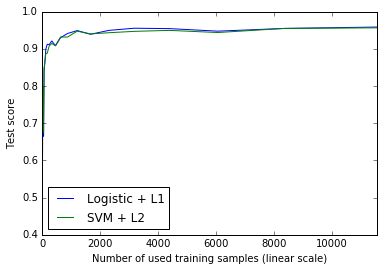

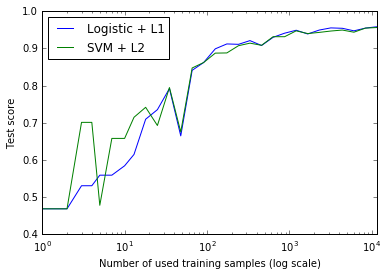

In [133]:
# plt.plot(amounts, svm_scores)
# ax = plt.gca()
# ax.plot(amounts, log_scores)
# _ = 

df = pd.DataFrame(index=pd.Index(amounts), data={
    "SVM + L2": svm_scores,
    "Logistic + L1": log_scores
})

ax = df.plot()
ax.set_xlabel("Number of used training samples (linear scale)")
ax.set_ylabel("Test score")
ax = df.plot(logx=True)
ax.set_xlabel("Number of used training samples (log scale)")
ax.set_ylabel("Test score")

One can clearly see in the above plot that the online SVM algorithm approaches its maximum accuracy quite early on (even after only processing about 10% of the training data).

Note: the fluctuations are due to the random shuffling of the data and can be accounted for by choosing multiple subsamples of the training data for every count on the X-axis (this has been omitted since it can get quite time-consuming).